## Import required modules

In [1]:
# ===========================================================================
# import required modules
# ===========================================================================
import os

# ===================
# for array manipulations, etc.
# ===================
import random
import numpy as np

# ===================
# for visualization
# ===================
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

# ===================
# pytorch for CNN related things
# ===================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Set path to the STL dataset


In [2]:
STL_path = 'stl10_binary'

## Load the dataset (images + labels)


In [3]:

# ===================
# function to load the dataset and format the data as required for further processing 
# ===================
# inputs:
#    split: string denoting whether the train or the test data is to be loaded 
# outputs:
#    X: dataset inputs (images)
#    y: dataset outputs (labels for the images)
# ===================
def load_split(dataset_root, split):
    X_path = '{}/{}_X.bin'.format(dataset_root, split)
    y_path = '{}/{}_y.bin'.format(dataset_root, split)
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y

# ===================
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split(STL_path, 'train')
full_test_X, full_test_y = load_split(STL_path, 'test')

# ===================
# read the names of the classes in the dataset
# ===================
with open('{}/class_names.txt'.format(STL_path)) as f:
    full_class_names = f.readlines()
  
 # ===================
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]

# ===================
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)
-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


## Explore a few samples of the dataset

In [4]:
# ===========================================================================
# Explore a few samples of the dataset
# (repeat the following cell for different output by pressing Ctrl-Enter on it instead of Shift-Enter)
# ===========================================================================

# ===================
# function to show an example image and its label
# ===================
# inputs:
#    X: image
#    y: label
#    class_names: list of names of all classes so that the class name corresponding to the label can be identified
# outputs:
#    None
# ===================
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

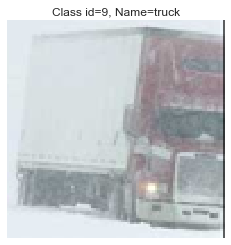

In [5]:
# ===================
# choose a random image and display it 
# you may run this cell multiple times to get an idea of the different images in the dataset
# alternatively, modify the function 'visualize_sample' to display several (4/8/16) different images along with their labels
# ===================
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

# Train a 2-class classifier. 

First we will generate a dataset with just two classes, 'cat' and 'ship'

In [6]:
# ===================
# Let's select from the dataset only samples of classes 'cat' and 'ship'.
# We have arbitrarily chosen these two classes.
# You may try some other pair of classes if you wish to.
# ===================
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

# ===================
# function to delete all the classes other than the cat and ship classes
# ===================
# inputs:
#    X: images from all classes
#    y: labels from all classes
#    split: train / test
# outputs:
#    X_out: images from only cats and ships
#    y_out: labels from only cats and ships
# ===================
def subsplit_two_classes(X, y, split):
    
    indices = np.where(np.logical_or(y==ID_C1_OLD,
                                   y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.int) * ID_C1_NEW + \
            (y_out == ID_C2_OLD).astype(np.int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

# ===================
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


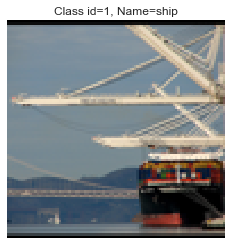

In [7]:
# ===================
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

## Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping


In [8]:
class ArrayDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]
  
 # ===================
 # set the batch size here
 # ===================
BATCH_SIZE = 8

# ===================
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# ===================
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                     batch_size=1,
                                     shuffle=True)

## Define the neural network


In [9]:
class CNN(nn.Module):
  
  # ===================
  # the network architecture is defined here
  # documentation of some useful functions:
  #     https://pytorch.org/docs/stable/nn.html#conv2d
  #     https://pytorch.org/docs/stable/nn.html#batchnorm2d
  #     https://pytorch.org/docs/stable/nn.html#maxpool2d
  #     https://pytorch.org/docs/stable/nn.html#linear
  #     https://pytorch.org/docs/stable/nn.html#batchnorm1d
  # ===================
    def __init__(self, num_out_classes):
    
        super(CNN, self).__init__()
        
        num_filters = [3, 6, 12, 24, 64]
    
        # expected size of input to following layer: 3x96x96
        self.conv1 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # expected size of input to following layer:
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[1])
        # expected size of input to following layer:
        self.relu1 = nn.ReLU()
        # expected size of input to following layer:
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # expected size of input to following layer:
        self.conv2 = nn.Conv2d(in_channels=num_filters[1],
                               out_channels=num_filters[2],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # expected size of input to following layer:
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[2])
        # expected size of input to following layer:
        self.relu2 = nn.ReLU()
        # expected size of input to following layer:
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # expected size of input to following layer:
        self.conv3 = nn.Conv2d(in_channels=num_filters[2],
                               out_channels=num_filters[3],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # expected size of input to following layer:
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[3])
        # expected size of input to following layer:
        self.relu3 = nn.ReLU()
        # expected size of input to following layer:
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # expected size of input to following layer:
        self.fc4 = nn.Linear(in_features=num_filters[3]*12*12,
                             out_features=num_filters[4])
        # expected size of input to following layer:
        self.bn4 = nn.BatchNorm1d(num_features=num_filters[4])
        # expected size of input to following layer:
        self.relu4 = nn.ReLU()

        # expected size of input to following layer:
        self.fc5 = nn.Linear(in_features=num_filters[4],
                             out_features=num_out_classes)
        
        # single-layer perceptron neural network
        self.perceptron = nn.Linear(in_features=3*96*96,
                                    out_features=num_out_classes)
        
        layers = [self.conv1, self.bn1, self.relu1, self.pool1, self.conv2, self.bn2, self.relu2, self.pool2,
                  self.conv3, self.bn3, self.relu3, self.pool3]
        outLayers = [self.fc4, self.bn4, self.relu4, self.fc5]
        self.convNet = nn.Sequential(*layers)
        self.outNet = nn.Sequential(*outLayers)

    # ===================
    # define the forward pass through the network using the operations defined in the init function
    # ===================
    def forward(self, x):
        # bring input to [-1,1] range
        x = x.float() / 128.0 - 1.0
        # ===================
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        # (to be implemented)
        # ===================
        x = self.convNet(x)
        x = x.view(-1, 24*12*12)
        x = self.outNet(x)
        
        return x

## Function to compute the accuracy of the CNN

In [10]:
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):
  
    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    trueLabels = np.array([])
    predictedLabels = np.array([])
    
    for i, batch in enumerate(data_loader):

        # get the inputs and labels
        X_batch, y_batch = batch

        # calculate predictions given a batch of samples
        predictions_batch = cnn(X_batch)

        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)

        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]

        out_accuracy = int(total_accuracy) * 1.0 / total_samples
        
        trueLabels = np.concatenate((trueLabels, y_batch.numpy()))
        predictedLabels = np.concatenate((predictedLabels, vals.numpy()))

    if print_output:
        print('Accuracy over "{}" split is {:02f}%'.format(split, 100 * out_accuracy))

    return trueLabels, predictedLabels, 100 * out_accuracy

def confusion_matrix(labels_ground_truth, labels_predicted, C):
    """
    Compute the confusion matrix based on the ground truth labels and the respective predictions.
    Inputs:
        |labels_ground_truth|: 1D numpy.ndarray containing the ground truth labels, with dimensions S-by-1.
        |labels_predicted|: 1D numpy.ndarray containing the predicted labels, with same dimensions as
                            |labels_ground_truth|.
    """

    # Initialize confusion matrix to zero values.
    conf = np.zeros((C, C))

    # Use definition of confusion matrix to compute its values: rows correspond to ground truth labels, columns to
    # predictions.
    np.add.at(conf, (labels_ground_truth, labels_predicted), 1)

    return conf

## Function for training the model. 


In [11]:
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False):
  
    # ===================
    # define the loss to be minimized
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss
    # ===================
    criterion = nn.CrossEntropyLoss()

    # ===================
    # create an optimizer 
    # You can read more about optimizers here: https://pytorch.org/docs/stable/optim.html
    # You may try with different optimizers and check if that makes any difference
    # For any one optimizer, try changing the learning rate and observe the effect.
    # ===================
    optimizer = optim.SGD(cnn.parameters(),
                        lr = learning_rate,
                        momentum = 0.9)

    # ===================
    # set the model into training mode
    # ===================
    cnn.train() 

    tr_acc = []
    ts_acc = []

    # ===================
    # In each epoch, run the optimizer operation on each batch
    # ===================
    for epoch in range(num_epochs):
            
        epoch_loss = 0.0

        for i, batch in enumerate(loader_train):

            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            predictions_batch = cnn(X_batch)
            
            # calculate loss for the provided predictions and ground truth labels
            prediction_batch = torch.max(predictions_batch, 1)[1]
            loss = criterion(predictions_batch, y_batch)

            epoch_loss += float(loss)

            # backward pass
            loss.backward()

            # update learnable parameters according to gradients
            optimizer.step()
            
        # ===================
        # track the training and test accuracy.
        # note that this adds quite a bit to the training time,
        # as things are running on the cpu currently.
        # this is usually a good debugging tool to see how the training is progressing
        # and is usually done when people train such networks on gpus.
        # ===================
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False)[2])
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False)[2])

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        plt.figure()
        plt.plot(np.array(tr_acc), 'o')
        plt.plot(np.array(ts_acc), 'x')
        plt.legend(['training accuracy', 'test accuracy'])
        plt.xlabel('training iterations')
        plt.show()
        plt.close()

    print('Finished Training')

## Create an instance of the above defined CNN class and compute it's accuracy before training. What do you expect the accuracy to be??

Accuracy over "train" split is 50.000000%
Accuracy over "test" split is 50.000000%


(array([0.5, 1.5]), [Text(0, 0.5, 'cat'), Text(0, 1.5, 'ship')])

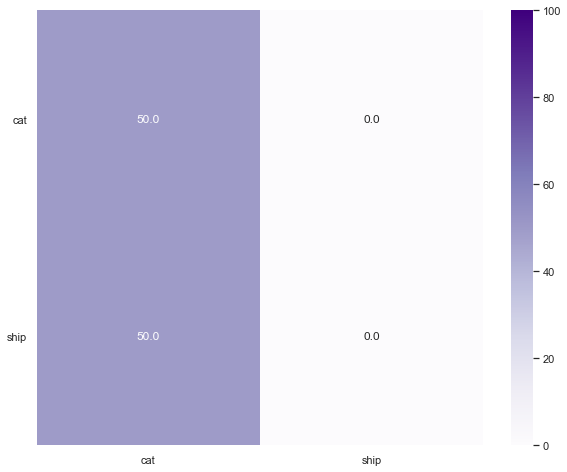

In [12]:
# ===========================================================================
# create an instance of the above defined CNN class
# ===========================================================================
cnn_two_classes = CNN(num_out_classes = 2)

# ===========================================================================
# compute the accuracy of the CNN
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

trueLabels, predictedLabels, acc = compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

cmat = confusion_matrix(trueLabels.astype(int), predictedLabels.astype(int), 2)
two_class = [full_class_names[i] for i in [3, 8]]
plt.figure(figsize=(10,8))
sns.heatmap(cmat/(cmat.sum(axis=0)+0.01)*100, 
            annot=cmat/(cmat.sum(axis=0)+0.01)*100, 
            xticklabels=two_class, yticklabels=two_class, fmt='.1f', cmap='Purples', vmin = 0, vmax=100)
plt.yticks(rotation=0)

## Train the network now and reevaluate it's accuracy

Epoch 1/10 training loss 0.364466
Epoch 2/10 training loss 0.233656
Epoch 3/10 training loss 0.151865
Epoch 4/10 training loss 0.110753
Epoch 5/10 training loss 0.063521
Epoch 6/10 training loss 0.034039
Epoch 7/10 training loss 0.014066
Epoch 8/10 training loss 0.006642
Epoch 9/10 training loss 0.001838
Epoch 10/10 training loss 0.000910


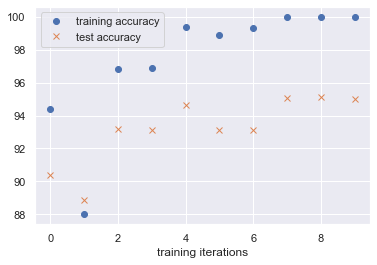

Finished Training
Accuracy over "train" split is 100.000000%
Accuracy over "test" split is 95.000000%


(array([0.5, 1.5]), [Text(0, 0.5, 'cat'), Text(0, 1.5, 'ship')])

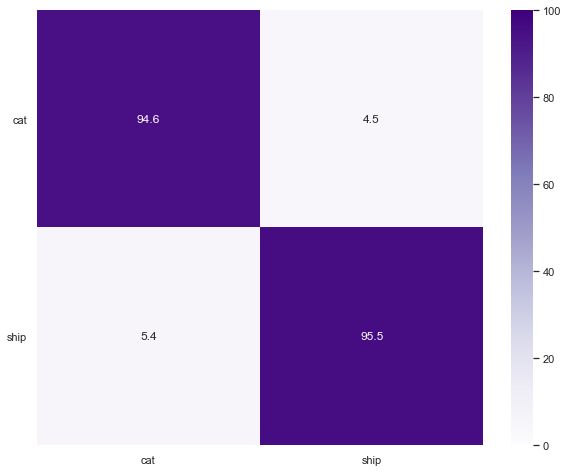

In [13]:
# ===========================================================================
# call the train function and wait for the magic to unfold ;)
# ===========================================================================
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 10,
      track_accuracy = True)

# ===========================================================================
# Let's reevaluate accuracy now. Did the magic happen?
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

trueLabels, predictedLabels, acc = compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

cmat = confusion_matrix(trueLabels.astype(int), predictedLabels.astype(int), 2)
two_class = [full_class_names[i] for i in [3, 8]]
plt.figure(figsize=(10,8))
sns.heatmap(cmat/cmat.sum(axis=0)*100, 
            annot=cmat/cmat.sum(axis=0)*100, 
            xticklabels=two_class, yticklabels=two_class, fmt='.1f', cmap='Purples', vmin = 0, vmax=100)
plt.yticks(rotation=0)

# Multi-class classification



The 2-class classification CNN works well. Now, let's try to apply the same approach to multi-class classification problem. Remember that the original dataset has 10 classes. So all that needs to be done is create a new CNN with 10 output classes, and train once again.






Accuracy over "train" split is 9.740000%
Accuracy over "test" split is 9.637500%


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'bird'),
  Text(0, 2.5, 'car'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'horse'),
  Text(0, 7.5, 'monkey'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')])

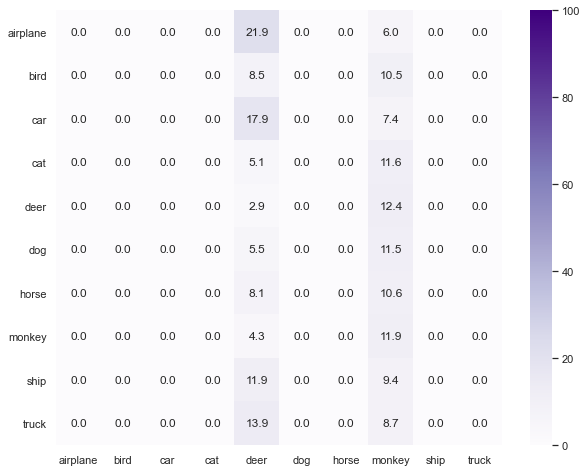

In [14]:
# ===========================================================================
# create a new instance of the CNN class, to do the classification for all the ten classes
# ===========================================================================
cnn_ten_classes = CNN(num_out_classes = 10)

# ===========================================================================
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

trueLabels, predictedLabels, acc = compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

cmat = confusion_matrix(trueLabels.astype(int), predictedLabels.astype(int), 10)
plt.figure(figsize=(10,8))
sns.heatmap(cmat/(cmat.sum(axis=0)+0.01)*100, 
            annot=cmat/(cmat.sum(axis=0)+0.01)*100, 
            xticklabels=full_class_names, yticklabels=full_class_names, fmt='.1f', cmap='Purples', vmin = 0, vmax=100)
plt.yticks(rotation=0)

Epoch 1/10 training loss 1.765814
Epoch 2/10 training loss 1.404834
Epoch 3/10 training loss 1.132048
Epoch 4/10 training loss 0.923811
Epoch 5/10 training loss 0.693005
Epoch 6/10 training loss 0.492758
Epoch 7/10 training loss 0.350530
Epoch 8/10 training loss 0.297489
Epoch 9/10 training loss 0.207855
Epoch 10/10 training loss 0.175249


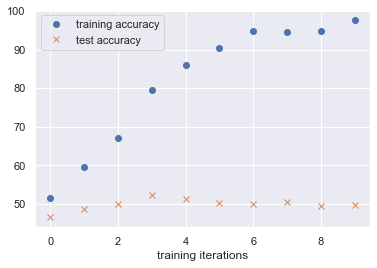

Finished Training
Accuracy over "train" split is 97.740000%
Accuracy over "test" split is 49.837500%


In [15]:
# ===========================================================================
# train this new CNN...
# ===========================================================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 10,
      track_accuracy = True)

# ===========================================================================
# compute the accuracy with the trained CNN...
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

trueLabels, predictedLabels, acc = compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'bird'),
  Text(0, 2.5, 'car'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'horse'),
  Text(0, 7.5, 'monkey'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')])

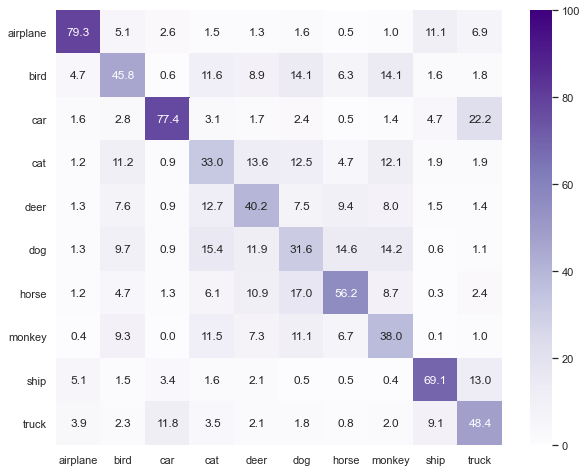

In [16]:
cmat = confusion_matrix(trueLabels.astype(int), predictedLabels.astype(int), 10)
plt.figure(figsize=(10,8))
sns.heatmap(cmat/cmat.sum(axis=0)*100, 
            annot=cmat/cmat.sum(axis=0)*100, 
            xticklabels=full_class_names, yticklabels=full_class_names, fmt='.1f', cmap='Purples', vmin = 0, vmax=100)
plt.yticks(rotation=0)